>[ Stochastic estimate of $\pi$](#scrollTo=N-xa8JwHBMs7)

>[ Rejection sampling](#scrollTo=VDQjyXBuKJsT)

>>[ Rejection sampling in a nutshell](#scrollTo=VDQjyXBuKJsT)

>>[ Rejection sampling of fractional gamma distribution](#scrollTo=VDQjyXBuKJsT)

>[ Importance sampling](#scrollTo=iJtpvMQKpfjw)



*Authors*: pmineault@, cgs@, with some counsel from rofer@, kpmurphy@, xiaojingw@

We show some examples of sampling in TensorFlow, building blocks of more elaborate MCMC procedures. 

The examples replicate some figures from the MCMC chapter in Kevin Murphy's book, [Machine Learning: A Probabilistic Perspective](https://mitpress.mit.edu/books/machine-learning-0).

In [1]:
%matplotlib inline

# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

distributions = tf.contrib.distributions

# Stochastic estimate of $\pi$

Compute $\pi$ by Monte Carlo integration, using conventional Numpy-based methods. The idea is to sample uniformily from a 1X1 square, and compute the proportion of samples that fall within a radius of 0.5 from the center of the square. This proportion is equal to $\pi/4$.

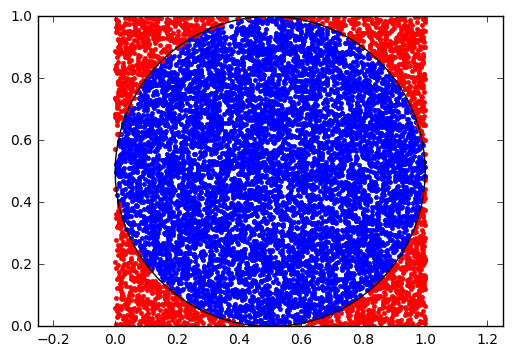

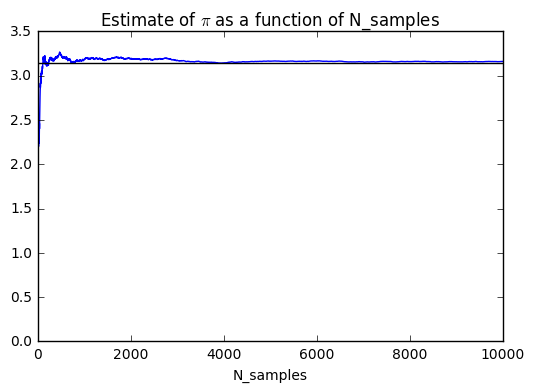

In [2]:
def compute_pi_conventional(N_samples=10000):
  """Compute a series of approximations for $\pi$ via MCMC.
  
  Idea: sample from a 1X1 square and compute the proportion of samples that fall
  within .5 from the center of the square. The estimate is the proportion of 
  accepted samples times 4.
  """
  samples   = np.random.rand(N_samples, 2)
  accepted  = ((samples - .5) ** 2).sum(1) < .5 ** 2
  estimates = 4 * accepted.cumsum() / (np.arange(N_samples) + 1.0)
  return (samples, accepted, estimates)
 
samples, accepted, estimates = compute_pi_conventional()
plt.plot(samples[accepted, 0], samples[accepted, 1], 'b.')
plt.plot(samples[~accepted, 0], samples[~accepted, 1], 'r.')
theta = np.arange(100) / 100.0 * 2 * np.pi
plt.plot(np.sin(theta) * .5 + .5, np.cos(theta) * .5 + .5, 'k-')
plt.axis('equal')

plt.figure()
plt.plot(estimates)
plt.plot([0, len(estimates)], [np.pi, np.pi], 'k-')
plt.xlabel('N_samples')
plt.title('Estimate of $\pi$ as a function of N_samples')

Do the same thing, in Tensorflow. There's a little bit more boilerplate, but then we get access to the extremely powerful distributions library, which will come in handy in later examples.

Instructions for updating:
Use `tf.global_variables_initializer` instead.


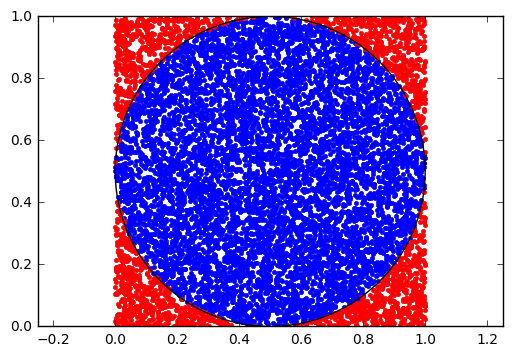

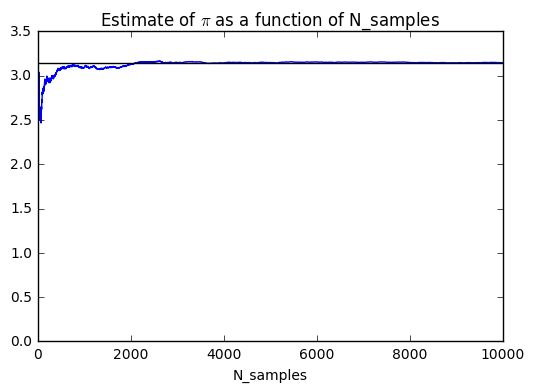

In [3]:
def compute_pi_tf(N_samples=10000):
  """Compute a series of approximations for $\pi$ via MCMC.
  
  Idea: sample from a 1X1 square and compute the proportion of samples that fall
  within .5 from the center of the square. The estimate is the proportion of 
  accepted samples times 4.
  """
  with tf.Graph().as_default():
    samples_tf = distributions.Uniform(0.0, 1.0).sample((N_samples, 2))
    accepted_tf = tf.reduce_sum((samples_tf - .5) ** 2, 1) < 0.5 ** 2
    estimates_tf = 4 * (tf.cumsum(tf.to_float(accepted_tf)) / 
                        tf.cumsum(tf.to_float(tf.ones_like(accepted_tf))))
    init_op = tf.initialize_all_variables()
    with tf.Session() as sess:
      sess.run(init_op) 
      samples, accepted, estimates = sess.run([samples_tf, 
                                               accepted_tf,
                                               estimates_tf])
  return (samples, accepted, estimates)
 
samples, accepted, estimates = compute_pi_tf()
plt.plot(samples[accepted, 0], samples[accepted, 1], 'b.')
plt.plot(samples[~accepted, 0], samples[~accepted, 1], 'r.')
theta = np.arange(100) / 100.0 * 2 * np.pi
plt.plot(np.sin(theta) * .5 + .5, np.cos(theta) * .5 + .5, 'k-')
plt.axis('equal')

plt.figure()
plt.plot(estimates)
plt.plot([0, len(estimates)], [np.pi, np.pi], 'k-')
plt.xlabel('N_samples')
plt.title('Estimate of $\pi$ as a function of N_samples')

# Rejection sampling

## Rejection sampling in a nutshell

Suppose we have a 1-d distribution $p(x)$ we want to sample from, and $q(x)$ is a proposal distribution that is easy to sample from. Then:

  * find an $M$ such that $M q(x) \ge p(x)$ for all x
  * Sample $x \sim q(x)$
  * Sample $u \sim \text{U}(0,1)$
  * Accept the sample if $p(x) > u M q(x)$

## Rejection sampling of fractional gamma distribution

The idea in section 20.3.2 is to sample from the distribution $p(x) = \text{Ga}(x|\alpha, \lambda)$ by rejection sampling from $q(x) = \text{Ga}(x|\lfloor \alpha \rfloor, \lambda - 1)$. 

Sample from a gamma distribution with fractional $\alpha$ by rejection sampling from a gamma distribution with integer $\alpha$. 

In [4]:
try:
  sess.close()
except:
  pass
sess = tf.InteractiveSession()

Start by creating variables corresponding to the parameters of the distributions, then define the distributions and the constant $M$.

In [6]:
alpha = tf.Variable(0.0, name='alpha')
lambda_ = tf.Variable(0.0, name='lambda_')

k = tf.floor(alpha)

p = distributions.Gamma(alpha, lambda_)
q = distributions.Gamma(k, lambda_ - 1)
uniform = distributions.Uniform(0.0, 1.0)


# Do this in log space for numerical stability.
M = tf.exp(p.log_pdf(alpha - k) - q.log_pdf(alpha - k))

init_op = tf.global_variables_initializer()
sess.run(init_op)

Sample from p(x) directly for sample values of $\alpha$, $\lambda$.

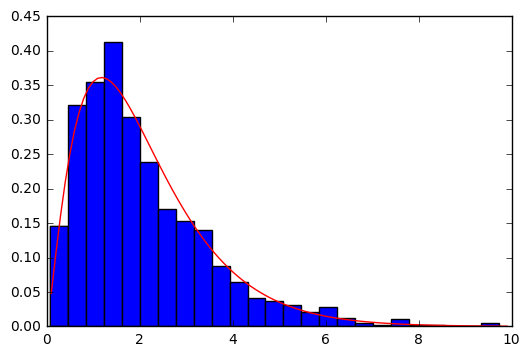

In [7]:
sess.run(tf.assign(alpha, 2.3))
sess.run(tf.assign(lambda_, 1.1))

N_samples = 1000
samples = p.sample(N_samples).eval()
plt.hist(samples, 25, normed=True)

# Also compute the pdf of the distribution.
x = np.arange(0.1, 10, .1).astype(np.float32)
plt.plot(x, sess.run(p.pdf(x)), 'r-')

Check graphically that $M q(x)$ is a bound on $p(x)$.

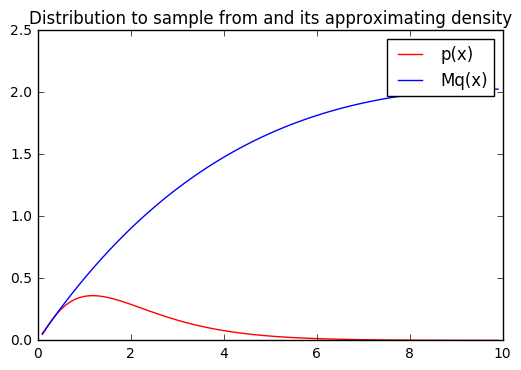

In [8]:
x = np.arange(0.1, 10, .1).astype(np.float32)
pdf_p = p.pdf(x).eval()
pdf_q = (M * q.pdf(x)).eval()

plt.plot(x, pdf_p, 'r-')
plt.plot(x, pdf_q, 'b-')
plt.legend(('p(x)', 'Mq(x)'))
plt.title('Distribution to sample from and its approximating density')

Sample from p(x) using rejection sampling.

Proposed sample mean: 19.83
Accepted sample mean: 2.32
True mean: 2.09
Accepted 190/10000 samples


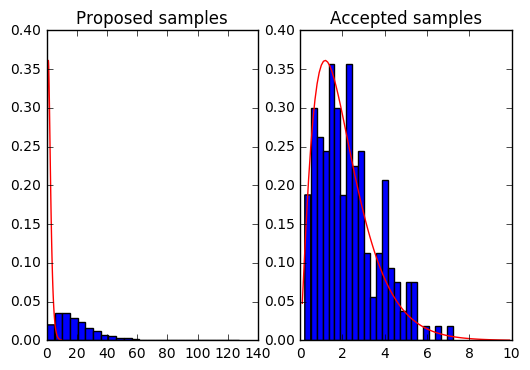

In [9]:
# Crank up the samples.
N_samples = int(1e4)

def rejection_sample(N, p, q, M):
  samples_tf = q.sample(N_samples)
  u = uniform.sample(N_samples)
  is_accepted = p.pdf(samples_tf) > u * M * q.pdf(samples_tf)
  accepted_samples_tf = tf.boolean_mask(samples_tf, is_accepted)

  # Tricky TensorFlow thing: it's important to use sess.run simultaneously on 
  # both sets of variables, otherwise sampling will be done twice, and the 
  # assert will not be true.
  samples, accepted_samples = sess.run([samples_tf, accepted_samples_tf])
  
  assert all([x in samples for x in accepted_samples])

  return samples, accepted_samples

samples, accepted_samples = rejection_sample(N_samples, p, q, M)

for i, d in enumerate([(samples, 'Proposed samples'),
                       (accepted_samples, 'Accepted samples')]):
  plt.subplot(121 + i)
  plt.hist(d[0], 25, normed=True)
  plt.title(d[1])

  # Also compute the pdf of the distribution.
  x = np.arange(0.1, 10, .1).astype(np.float32)
  plt.plot(x, sess.run(p.pdf(x)), 'r-')

print "Proposed sample mean: %.2f" % samples.mean()
print "Accepted sample mean: %.2f" % accepted_samples.mean()
print "True mean: %.2f" % p.mean().eval()
print "Accepted %d/%d samples" % (len(accepted_samples), len(samples))

This works, although it's very inefficient (~ 2% of samples accepted).

# Importance sampling

$\newcommand{vx}{\boldsymbol{x}}$

Here the idea is to get around the (generally) poor sampling efficiency of
the rejection sampling method. We assume that the objective is to estimate
some expectation:

$$
I = \mathbb{E}[f] = \int f(\vx) p(\vx) d\vx
$$

We can use a clever trick to rewrite this as an expectation over a simpler
distribution $q$:

$$
\mathbb{E}[f] = \int f(\vx) \frac{p(\vx)}{q(\vx)} q(\vx)d\vx = 
\mathbb{E}_q[w f(\vx)] \approx
\frac{1}{S} \sum_{s=1}^S w_s f(\vx^s) = \hat{I}
$$

where $w := p(\vx)/q(\vx)$, and $w_s := p(\vx^s) / q(\vx^s)$. The $w$'s are
called the *importance weights*.

In [10]:
# Let's try this on the fractional gamma from above, using the same q as
# proposal distribution. Suppose that we want to estimate the
# expectation of some f(x). We'll try f(x) = x and f(x) = 1 / (1 + x).

def importance_sample(p, q, f, x):
  samples_from_q = q.sample_n(n = N_samples).eval()
  importance_weights = p.pdf(x) / q.pdf(x)
  estimated_expectation_of_f = tf.reduce_mean(f * importance_weights)

  result, = sess.run([estimated_expectation_of_f],
                     feed_dict={x: samples_from_q})
  return result

x = tf.placeholder(dtype=tf.float32)

# Try it with two functions: x and 1 / 1 + x
funs = [(x, 'x'), 
        (1. / (1. + x), '1. / (1. + x)')]

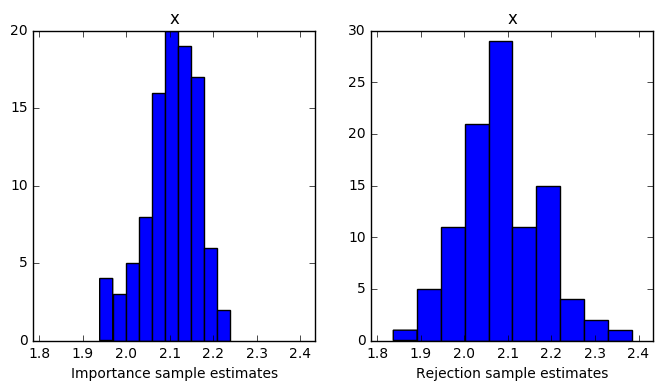

IS estimates mean: 2.101887
IS estimates stddev: 0.061621
RS estimates mean: 2.082839
RS estimates stddev: 0.093302


In [ ]:
for fun, fun_name in funs:
  plt.figure(figsize=(8, 4))
  is_estimates = []
  rs_estimates = []

  # Let's get a bunch of estimates and see which method has greater variance. This
  # is very slow because we're making umpteen calls to sess.run instead of piling
  # everything into one graph.
  for i in range(100):
    is_estimates.append(importance_sample(p, q, fun, x))
    result, = sess.run([fun], feed_dict={x:rejection_sample(N_samples, p, q, M)[1]})
    rs_estimates.append(result.mean())

  rg = (min(is_estimates + rs_estimates) - .05, 
        max(is_estimates + rs_estimates) + .05)
    
  ax = plt.subplot(121)
  #ax.set_ylim(top=5)
  ax.hist(np.array(is_estimates), bins=10)
  ax.set_xlabel("Importance sample estimates")
  ax.set_xlim(rg[0], rg[1])
  plt.title(fun_name)

  ax = plt.subplot(122)
  #ax.set_ylim(top=5)
  ax.hist(np.array(rs_estimates), bins=10)
  ax.set_xlabel("Rejection sample estimates")
  ax.set_xlim(rg[0], rg[1])

  plt.title(fun_name)
  plt.show()

  print("IS estimates mean: %f" % np.array(is_estimates).mean())
  print("IS estimates stddev: %f" % np.array(is_estimates).std())
  print("RS estimates mean: %f" % np.array(rs_estimates).mean())
  print("RS estimates stddev: %f" % np.array(rs_estimates).std())

Very interestingly, which estimate is more efficient depends on the integral to be estimated. The proposal distribution has a higher mean than the sample distribution, so IS is more efficient for integrating increasing functions e.g. $f(x) = x$. The opposite is true for decreasing functions, e.g. $f(x) = 1 / (1 +x)$